# Hamming smoothing

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
from melodic_contour import *
matplotlib.style.use('styles.mplstyle')

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import tslearn
from tslearn.metrics import cdist_dtw

from scipy.spatial import distance_matrix
from unidip.dip import diptst as diptest

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Load data

In [2]:
dfs, all_contours = load_datasets(normalize=False)

In [3]:
def filter_contours(name, min_length=6, max_length=10, dfs=dfs, N=500):
    np.random.seed(0)
    df = dfs[name]
    okay = (df['phrase_length'] >= min_length) & (df['phrase_length'] <= max_length)
    contours = all_contours[name][okay]
    indices = np.random.choice(np.arange(len(contours)), N, replace=False)
    return contours[indices, :], indices

In [4]:
N = 200
erk, erk_idx = filter_contours('erk', 6, 10, N=N)
han, han_idx = filter_contours('han', 6, 10, N=N)
gre, gre_idx = filter_contours('liber-antiphons', 6, 10, N=N)

In [5]:
contours = np.concatenate((erk, han, gre), axis=0)

## Smoothing

In [247]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [187]:
def hamming_smoothing(xs, window_len=5):
    # A smoothing function using a Hamming window
    # https://scipy.github.io/old-wiki/pages/Cookbook/SignalSmooth.html
    assert window_len % 2 == 1
    prefix = [xs[0]] * (window_len - 1)
    suffix = [xs[-1]] * (window_len - 1)
    padded_xs = np.concatenate([prefix, xs, suffix])
    window = np.hamming(window_len)
    ys = np.convolve(window/window.sum(), padded_xs, mode='valid')
    return ys[int(window_len/2):-int(window_len/2)]

# plt.figure(figsize=cm2inch(6, 5))
# xs = np.arange(10)
# plt.plot(xs)
# plt.plot(hamming_smoothing(xs))

## Comparison with Savitzky-Golay/LOESS

We also try smoothing curves using the **Savitzky-Golay filter**, or **LOESS** (locally estimated scatterplot smoothing). In every window of 15 timesteps, it computes a third-degree polynomial approximation to original contour (using least squares regression). The value at the center of the window is used as the smoothing.

On this type of data the two types of smoothing appear to have very similar effects. S-G sometimes 'overshoots' at sharp corners, and the Hamming smoothing does not show such artefacts. We therefore opt for the Hanning smoothing.

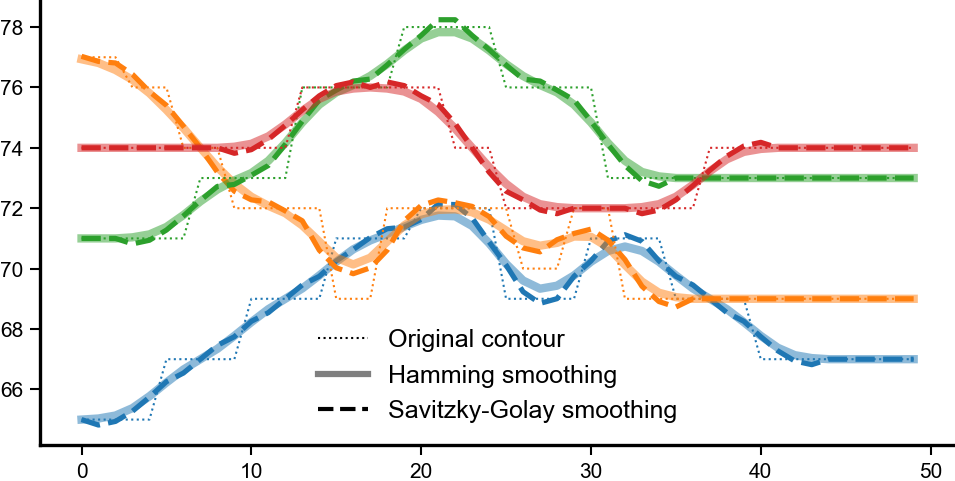

In [193]:
plt.figure(figsize=cm2inch(10, 5))

np.random.seed(0)
for i in np.random.randint(len(contours), size=(4)):
    ys = contours[i, :]
    ys_hamming = hamming_smoothing(ys, window_len=9)
    ys_savgol = savgol_filter(ys, window_length=9, polyorder=3, mode='nearest')

    l1, = plt.plot(ys, lw=.5, ls=':')
    l2, = plt.plot(ys_hamming, color=l1.get_color(), lw=2, alpha=.5)
    l3, = plt.plot(ys_savgol, color=l1.get_color(), ls='--', lw=1.25)
    
plt.plot(0, 70, 'k', lw=.5, ls=':', label='Original contour') 
plt.plot(0, 70, 'k', label='Hamming smoothing', alpha=.5) 
plt.plot(0, 70, 'k', ls='--', lw=1, label='Savitzky-Golay smoothing') 
plt.legend()

## Smooth derivatives

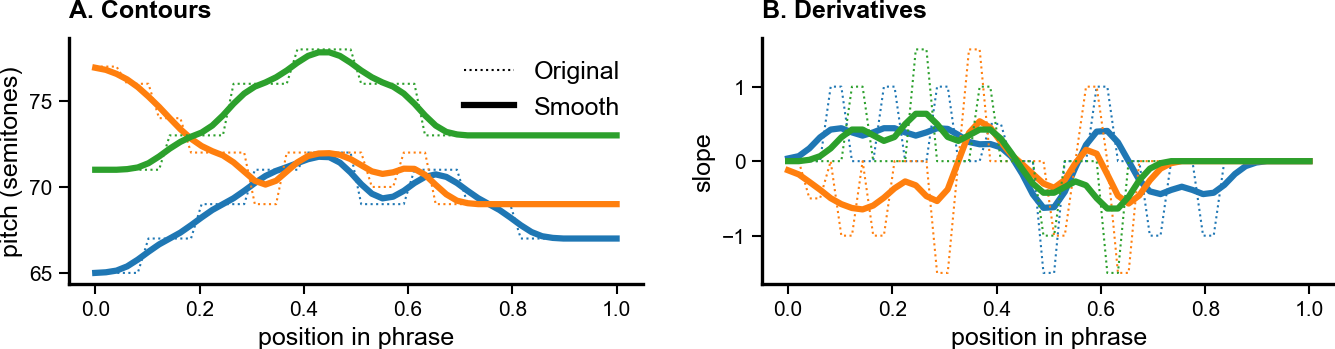

In [246]:
plt.figure(figsize=cm2inch(12, 3.5))
np.random.seed(0)
indices = np.random.randint(len(contours), size=(3))
window_len = 9
xs = np.linspace(0, 1, 50)

plt.subplot(121)
title('A. Contours')
for i in indices:
    ys = contours[i, :]
    ys_hamming = hamming_smoothing(ys, window_len=window_len)
    l1, = plt.plot(xs, ys, lw=.5, ls=':')
    l2, = plt.plot(xs, ys_hamming, color=l1.get_color())
plt.xlabel('position in phrase')
plt.ylabel('pitch (semitones)')
plt.plot(0, 70, 'k', lw=.5, ls=':', label='Original') 
plt.plot(0, 70, 'k', label='Smooth') 
plt.legend();

plt.subplot(122)
title('B. Derivatives')
for i in indices:
    ys = contours[i, :]
    ys_hamming = hamming_smoothing(ys, window_len=window_len)
    l1, = plt.plot(xs, np.gradient(ys), lw=.5, ls=':')
    l2, = plt.plot(xs, np.gradient(ys_hamming), color=l1.get_color())
plt.xlabel('position in phrase')
plt.ylabel('slope')
    
plt.tight_layout()
plt.savefig('../figures/figX-smoothing.pdf')

In [255]:
# smooth_contours = np.array([hamming_smoothing(c, 11) for c in contours])
# smooth_derivatives = np.array([np.gradient(c) for c in smooth_contours])
# dm = cdist_dtw(smooth_derivatives, smooth_derivatives)